In [40]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchsummary import summary
from collections import OrderedDict
import torchvision.transforms as transforms



In [10]:
vgg = models.vgg16(pretrained=True)
vgg.cuda()
summary(vgg, (3, 224, 224))
vgg.cpu()

c:\Users\sumon\miniconda3\envs\smai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sumon\miniconda3\envs\smai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), #0
            nn.ReLU(),                                            #1
        
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #2
            nn.ReLU(),                                             #3
            nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True), #4
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    #5
            nn.ReLU(),                                                 #6
        
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),   #7
            nn.ReLU(),                                                  #8
            nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True), #9
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),     #10
            nn.ReLU(),                                                  #11
        
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    #12
            nn.ReLU(),                                                  #13
        
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    #14
            nn.ReLU(),                                                  #15
            nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True), #16
        
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),        #17
            nn.ReLU(),                                                   #18
        
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),     #19
            nn.ReLU(),                                                   #20
        
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),     #21
            nn.ReLU(),                                                   #22
            nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True), #23

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    #24
            nn.ReLU(),                                                   #25

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),     #26
            nn.ReLU(),                                                   #27

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),     #28
            nn.ReLU(),                                                   #29
            nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices=True), #30
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 1000)
        )
        
        self.outputs = [0]*len(self.features)
        self.indices = dict()

        self.deconv = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
            
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),

            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            
            nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False)
        )


    def forward(self, x):
        for i, op in self.features:
            if isinstance(op, nn.MaxPool2d):
                x, indices = op(x)
                self.outputs[i]=x
                self.indices[i]=indices
            else:
                x=op(x)
                self.outputs[i]=x
        x = x.reshape(x.size(0), -1)
        x=self.classifier(x)
        return x
    
    def d_forward(self, x, layer):
        if layer < 1 or layer > 13:
            print("layer should be between 1-13")
            return False
        if layer == 13:
            x=self.deconv[0](x, self.indices[30], output_size=self.outputs[29].shape[-2:])
            x=self.deconv[1](x)
            x=self.deconv[2](x)
            layer-=1
        if layer == 12:
            x=self.deconv[3](x)
            x=self.deconv[4](x)
            layer-=1
        if layer == 11:
            x=self.deconv[5](x)
            x=self.deconv[6](x)
            layer-=1
        if layer == 10:
            x=self.deconv[7](x, self.indices[23], output_size=self.outputs[22].shape[-2:])
            x=self.deconv[8](x)
            x=self.deconv[9](x)
            layer-=1
        if layer == 9:
            x=self.deconv[11](x)
            x=self.deconv[12](x)
            layer-=1
        if layer == 8:
            x=self.deconv[13](x)
            x=self.deconv[14](x)
            layer-=1
        if layer == 7:
            x=self.deconv[15](x, self.indices[16], output_size=self.outputs[15].shape[-2:])
            x=self.deconv[16](x)
            x=self.deconv[17](x)
            layer-=1
        if layer == 6:
            x=self.deconv[18](x)
            x=self.deconv[19](x)
            layer-=1
        if layer == 5:
            x=self.deconv[20](x)
            x=self.deconv[21](x)
            layer-=1
        if layer == 4:
            x=self.deconv[22](x, self.indices[9], output_size=self.outputs[8].shape[-2:])
            x=self.deconv[23](x)
            x=self.deconv[24](x)
            layer-=1
        if layer == 3:
            x=self.deconv[25](x)
            x=self.deconv[26](x)
            layer-=1
        if layer == 2:
            x=self.deconv[27](x, self.indices[4], output_size=self.outputs[3].shape[-2:])
            x=self.deconv[28](x)
            x=self.deconv[29](x)
            layer-=1
        if layer == 1:
            x=self.deconv[30](x)
            x=self.deconv[31](x)
        return x

In [35]:
vgg_weights = vgg.state_dict()
print(vgg_weights.keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


In [36]:
model = VGG16()
print(model.state_dict().keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'deconv.2.weight', 'deconv.4.weight', 'deconv.6.weight', 'deconv.9.weight', 'deconv.11.weight', 'deconv.13.weight', 'deconv.16.weight', 'deconv.18.weight', 'deconv.20.weight', 'deconv.23.weight', 'deconv.25.weight', 'deconv.28.weight', 'deconv.30.weight'])


In [37]:
new_dict = dict()
for key in vgg_weights.keys():
    if key in model.state_dict().keys():
        new_dict[key] = vgg_weights[key]
deconvs = ['deconv.2.weight', 'deconv.4.weight', 'deconv.6.weight', 'deconv.9.weight', 'deconv.11.weight',
           'deconv.13.weight', 'deconv.16.weight', 'deconv.18.weight', 'deconv.20.weight', 'deconv.23.weight', 
           'deconv.25.weight', 'deconv.28.weight', 'deconv.30.weight']
convs = ['features.28.weight', 'features.26.weight', 'features.24.weight', 'features.21.weight', 'features.19.weight', 
         'features.17.weight', 'features.14.weight', 'features.12.weight', 'features.10.weight', 'features.7.weight', 
         'features.5.weight', 'features.2.weight', 'features.0.weight']
for i in range(0, 13):
    # print(new_dict[deconvs[i]].shape, vgg_weights[convs[i]].shape)
    new_dict[deconvs[i]] = vgg_weights[convs[i]]
model_dict = model.state_dict()
model_dict.update(new_dict)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [38]:
from PIL import Image

def image_preprocess(image):
    normalize = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = normalize(image).unsqueeze(0)
    return image

In [49]:
car = Image.open('car.jpg')
kids = Image.open('kids.jpg')
store = Image.open('store.jpg')
dogo = Image.open('dogo.jpg')
images = [image_preprocess(img) for img in [car, kids, store, dogo]]

In [87]:
def plot_four(img):
    plt.figure(figsize=(8, 8))
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(np.transpose(img[0][0], (1, 2, 0)))
    axs[0, 1].imshow(np.transpose(img[1][0], (1, 2, 0)))
    axs[1, 0].imshow(np.transpose(img[2][0], (1, 2, 0)))
    axs[1, 1].imshow(np.transpose(img[3][0], (1, 2, 0)))
    for axi in axs.flat:
        axi.set_axis_off()
    plt.tight_layout()
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 800x800 with 0 Axes>

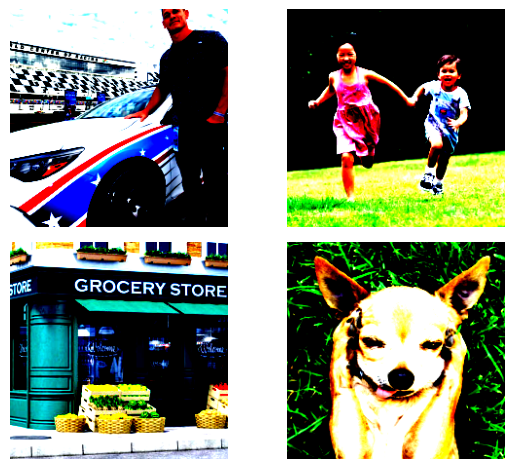

In [86]:
plot_four(images)

In [ ]:
#layer 1